# General description
This notebook represents the analysis of 3rd stage of the experiment - deconvolution of real images. Also the shape of PSF is compared 

In [1]:
import os

import numpy as np
import pandas as pd
import scipy, skimage
import math

from PIL import Image
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import clear_output

In [2]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [18]:
from scipy.spatial.distance import directed_hausdorff 

In [7]:
path_to = 'C:/Users/roman/Documents/Skoltech/real_data_ls_crop_09052020/' #deconvolved_bicubic_with_interp_esrgan\Richardson_Lucy'
os.chdir(path_to)
os.listdir()

['bicubic',
 'cells1-000006_bicubic.txt',
 'cells1-000006_int_esrgan.txt',
 'deconvolved_bicubic_with_gt2_kernel_modelled',
 'deconvolved_bicubic_with_ICY_EPIDEMIC',
 'deconvolved_bicubic_with_interp_esrgan',
 'deconvolved_bicubic_with_LsDeconv TU Wien2019',
 'deconvolved_bicubic_with_LsDeconv V2 XYvoxelSize1000 ZvoxelSize250 TU Wien2019',
 'deconvolved_bicubic_with_original_esrgan',
 'deconvolved_GT_new',
 'ICY_epidemic_estimated_PSF',
 'input',
 'int_esrgan',
 'real_data_ls_crop_09052020_combinated.zip',
 'Аннотация 2020-05-18 152154.jpg']

<hr>

##  Deconvolved images 

In [16]:
deconvolved_interp_gan = cv2.imread('deconvolved_bicubic_with_interp_esrgan/Richardson_Lucy/Final Display of RL0138.tif', -1)
deconvolved_original_gan = cv2.imread('deconvolved_bicubic_with_original_esrgan/Richardson_Lucy/Final Display of RL0138.tif', -1)
deconvolved_gt = cv2.imread('deconvolved_GT_new/Final Display of RL-10138.tif', -1)
deconvolved_icy = cv2.imread('deconvolved_bicubic_with_ICY_EPIDEMIC/RL/Final Display of RL0138.tif', -1)
deconvolved_ls_deconv = cv2.imread('deconvolved_bicubic_with_LsDeconv V2 XYvoxelSize1000 ZvoxelSize250 TU Wien2019/deconv_000138.tif', -1)
bicubic = cv2.imread('bicubic/crop_bicubic_C0001Z0138.tif', -1)
gan = cv2.imread('int_esrgan/crop_intesrgan_C0002Z0138.tif', -1)

deconvolved_gt = np.uint16(deconvolved_gt)

In [20]:
def sharpness(img, norm_coef = 30000000000):
    fftsum = np.abs(np.fft.fft2(img.copy())).sum()
    fftsum /= norm_coef
    return fftsum

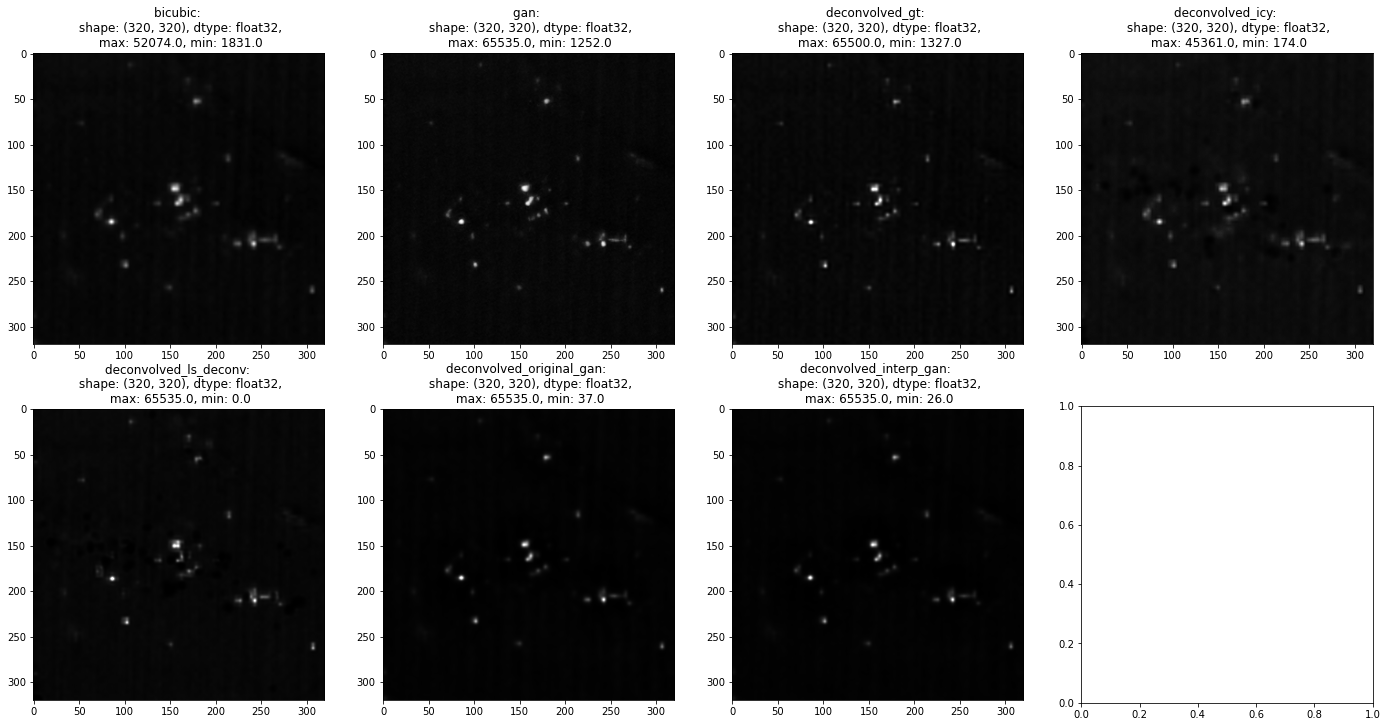

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(24)

for ax, image, name in zip(axes.ravel(), 
                           [bicubic, gan, deconvolved_gt, deconvolved_icy, deconvolved_ls_deconv, deconvolved_original_gan, deconvolved_interp_gan],
                           ['bicubic', 'gan', 'deconvolved_gt', 'deconvolved_icy', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan']
                          ):
    image = np.float32(image)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{name}: \n shape: {image.shape}, dtype: {image.dtype},\n max: {round(image.max())}, min: {round(image.min())}')

plt.show()

### Calculate metrics

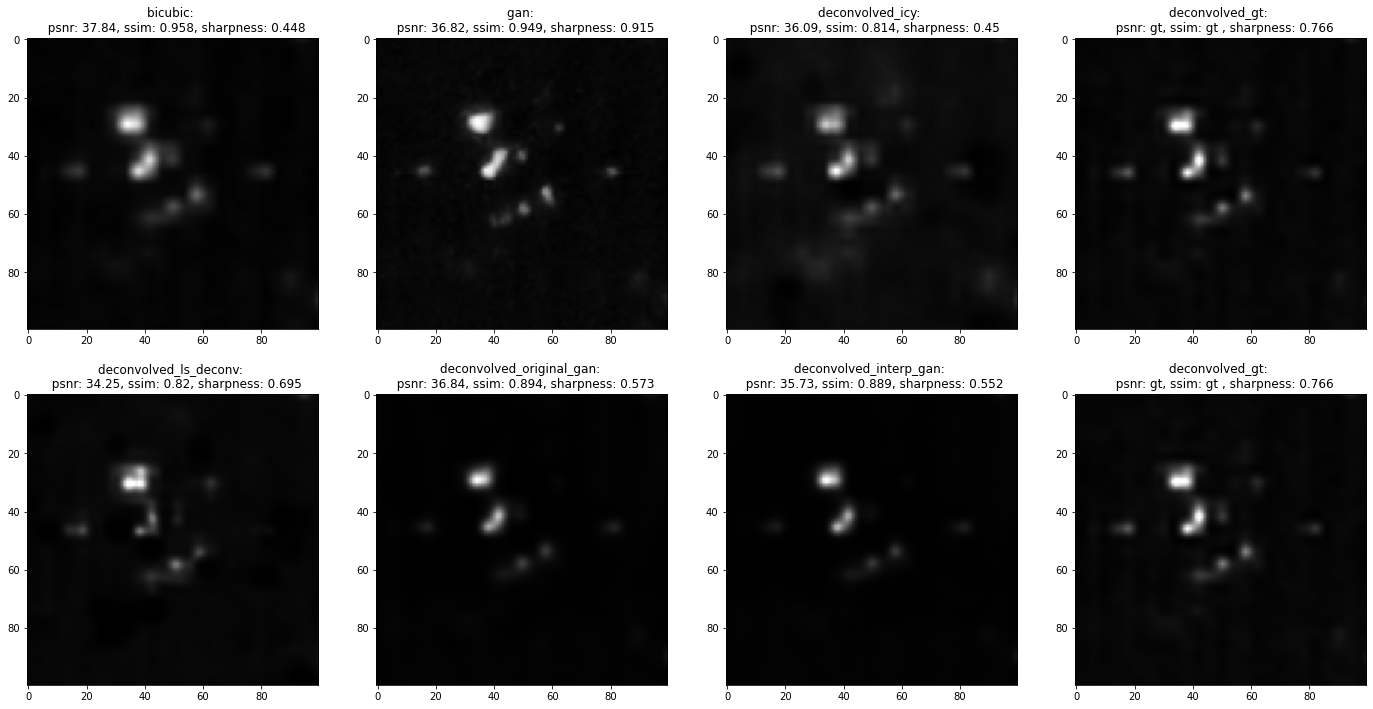

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(24)

img_true = deconvolved_gt[120:220,120:220]
img_true = np.float32(img_true)
img_true -= np.median(img_true)

img_true /= img_true.max()


for ax, image, name in zip(axes.ravel(), 
                           [bicubic, gan, deconvolved_icy, deconvolved_gt, deconvolved_ls_deconv, deconvolved_original_gan, deconvolved_interp_gan, deconvolved_gt],
                           ['bicubic', 'gan', 'deconvolved_icy', 'deconvolved_gt', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan', 'deconvolved_gt']
                          ):
    
    
    img_test = image[120:220,120:220]
    img_test = np.float32(img_test)
    img_test -= np.median(img_test)
    #img_test = np.uint16(img_test)
    #img_test -= img_test.min()
    img_test /= img_test.max()

    #img_test = np.clip(img_test, 0,1)
    
    sharpness_metric = sharpness(image)
    if name != 'deconvolved_gt':
        psnr_metric = psnr(image_true=img_true, image_test=img_test)
        ssim_metric = ssim(im1=img_true, im2=img_test)
        ax.set_title(f'{name}: \n  psnr: {round(psnr_metric,2)}, ssim: {round(ssim_metric,3)}, sharpness: {round(sharpness_metric,3)}')
    else:
        ax.set_title(f'{name}: \n  psnr: gt, ssim: gt , sharpness: {round(sharpness_metric,3)}')
    
    ax.imshow(img_test, cmap='gray') #np.log(img_test+1e-9)*
    

plt.show()

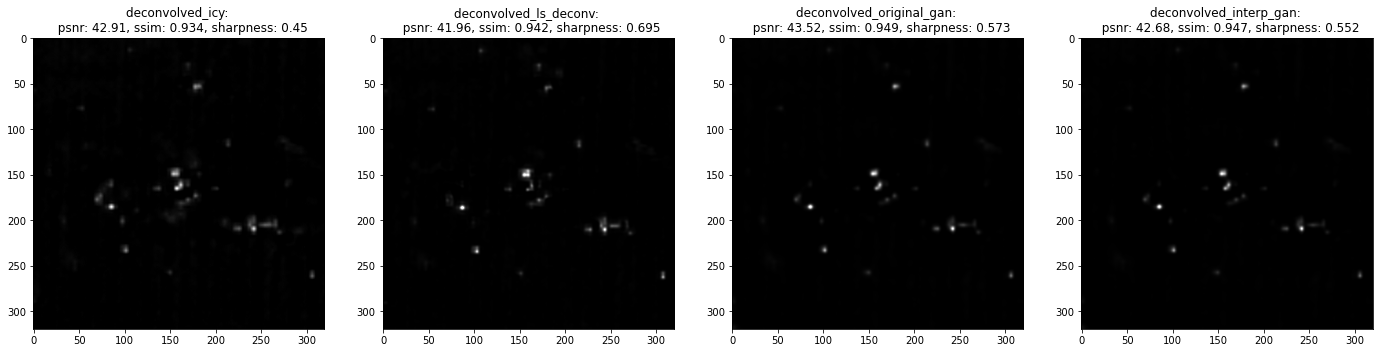

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(24)

img_true = deconvolved_gt#[120:220,120:220]
img_true = np.float32(img_true)
img_true -= img_true.min()
img_true /= img_true.max()
img_true -= np.median(img_true)

for ax, image, name in zip(axes.ravel(), 
                           [deconvolved_icy, deconvolved_ls_deconv, deconvolved_original_gan, deconvolved_interp_gan],
                           ['deconvolved_icy','deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan']
                          ):
    
    
    img_test = image#[120:220,120:220]
    img_test = np.float32(img_test)
    #img_test -= img_test.min()
    img_test /= img_test.max()
    img_test -= np.median(img_test)
    img_test = np.clip(img_test, 0,1)
    
    sharpness_metric = sharpness(image)
    if name != 'deconvolved_gt':
        psnr_metric = psnr(image_true=img_true, image_test=img_test)
        ssim_metric = ssim(im1=img_true, im2=img_test)
        ax.set_title(f'{name}: \n  psnr: {round(psnr_metric,2)}, ssim: {round(ssim_metric,3)}, sharpness: {round(sharpness_metric,3)}')
    else:
        ax.set_title(f'{name}: \n  psnr: gt, ssim: gt , sharpness: {round(sharpness_metric,3)}')
    
    ax.imshow(img_test, cmap='gray') #np.log(img_test+1e-9)*
    

plt.show()

### Construct axial slices from lateral

In [141]:
def get_slice(folder, number=200, axis=0):
    collector = np.zeros((320,320,320), dtype=np.uint16)

    files = os.listdir(folder)
    files = sorted( [f for f in files if f.endswith('.tif')] )

    for i in range(len(files)):
        tmp = cv2.imread(os.path.join(folder, files[i]), -1)
        collector[:,:,i] = np.uint16(tmp)
        
    if axis == 0:
        tslice = np.flip(collector[number,:,:].T, 0)
    if axis == 1:
        tslice = np.flip(collector[:,number,:].T, 0)
    if axis == 2:
        tslice = collector[:,:, number]
    
    return tslice

In [148]:
deconvolved_interp_gan_2 = get_slice('deconvolved_bicubic_with_interp_esrgan/Richardson_Lucy/', number=200, axis=0)
deconvolved_original_gan_2 = get_slice('deconvolved_bicubic_with_original_esrgan/Richardson_Lucy/', number=200, axis=0)
deconvolved_gt_2 = get_slice('deconvolved_GT_new/', number=200, axis=0)
deconvolved_icy_2 = get_slice('deconvolved_bicubic_with_ICY_EPIDEMIC/RL/', number=200, axis=0)
deconvolved_ls_deconv_2 = get_slice('deconvolved_bicubic_with_LsDeconv V2 XYvoxelSize1000 ZvoxelSize250 TU Wien2019/', number=200, axis=0)
bicubic_2 = get_slice('bicubic/', number=200, axis=0)
gan_2 = get_slice('int_esrgan/', number=200, axis=0)

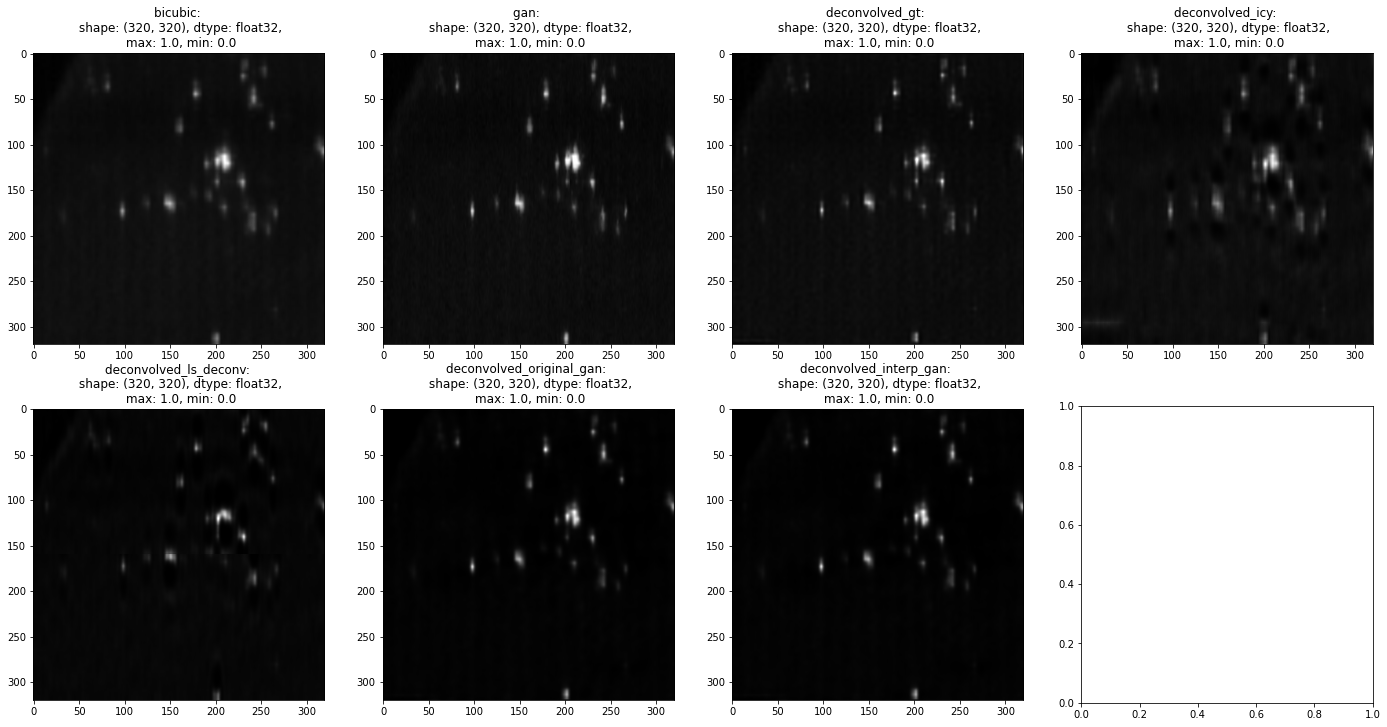

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(24)

for ax, image, name in zip(axes.ravel(), 
                           [bicubic_2, gan_2, deconvolved_gt_2, deconvolved_icy_2, deconvolved_ls_deconv_2, deconvolved_original_gan_2, deconvolved_interp_gan_2],
                           ['bicubic', 'gan', 'deconvolved_gt', 'deconvolved_icy', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan']
                          ):
    image = np.float32(image)
    image -= image.min()
    image /= image.max()
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{name}: \n shape: {image.shape}, dtype: {image.dtype},\n max: {round(image.max())}, min: {round(image.min())}')

plt.show()

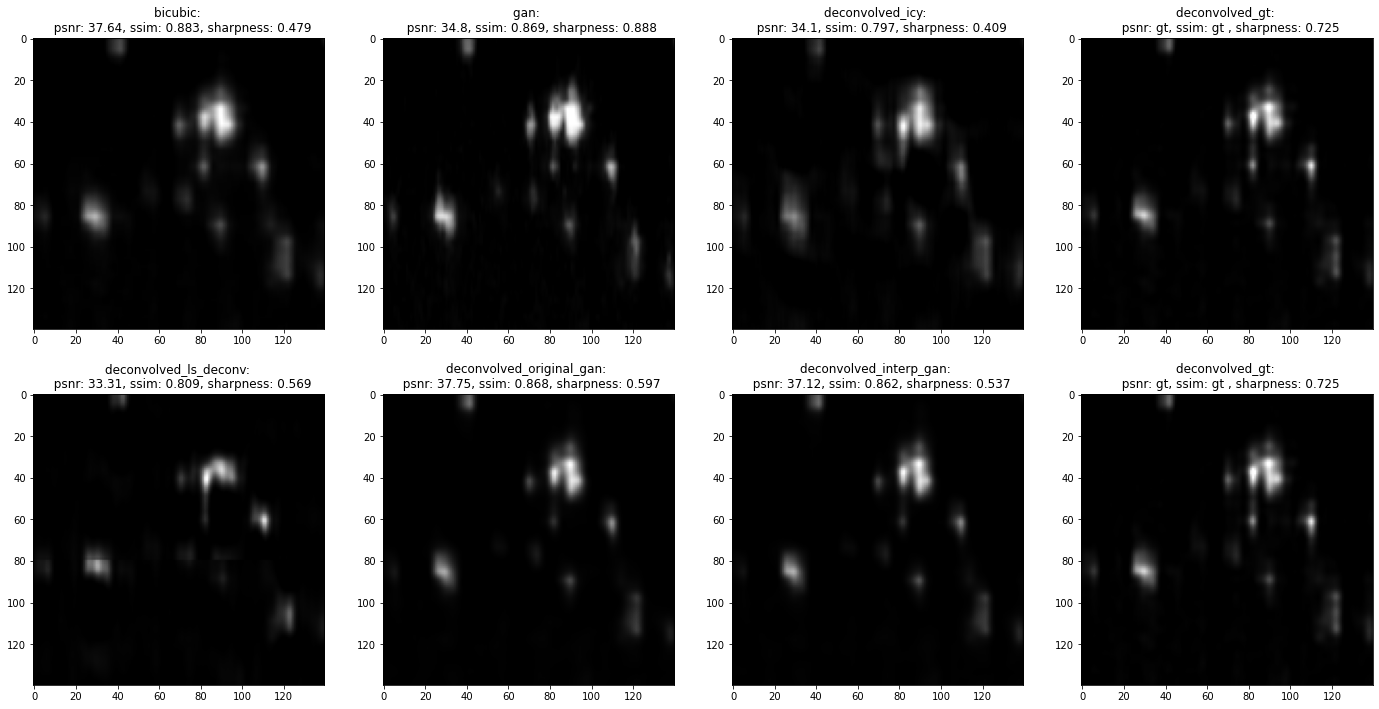

In [153]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(24)

img_true = deconvolved_gt_2[80:220,120:260]
img_true = np.float32(img_true)
img_true -= img_true.min()
img_true /= img_true.max()
img_true -= np.median(img_true)

for ax, image, name in zip(axes.ravel(), 
                           [bicubic_2, gan_2, deconvolved_icy_2, deconvolved_gt_2, deconvolved_ls_deconv_2, deconvolved_original_gan_2, deconvolved_interp_gan_2, deconvolved_gt_2],
                           ['bicubic', 'gan', 'deconvolved_icy', 'deconvolved_gt', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan', 'deconvolved_gt']
                          ):
    
    
    img_test = image[80:220,120:260]
    img_test = np.float32(img_test)
    #img_test -= img_test.min()
    img_test /= img_test.max()
    img_test -= np.median(img_test)
    img_test = np.clip(img_test, 0,1)
    
    sharpness_metric = sharpness(image)
    if name != 'deconvolved_gt':
        psnr_metric = psnr(image_true=img_true, image_test=img_test)
        ssim_metric = ssim(im1=img_true, im2=img_test)
        ax.set_title(f'{name}: \n  psnr: {round(psnr_metric,2)}, ssim: {round(ssim_metric,3)}, sharpness: {round(sharpness_metric,3)}')
    else:
        ax.set_title(f'{name}: \n  psnr: gt, ssim: gt , sharpness: {round(sharpness_metric,3)}')
    
    ax.imshow(img_test, cmap='gray') #np.log(img_test+1e-9)*
    

plt.show()

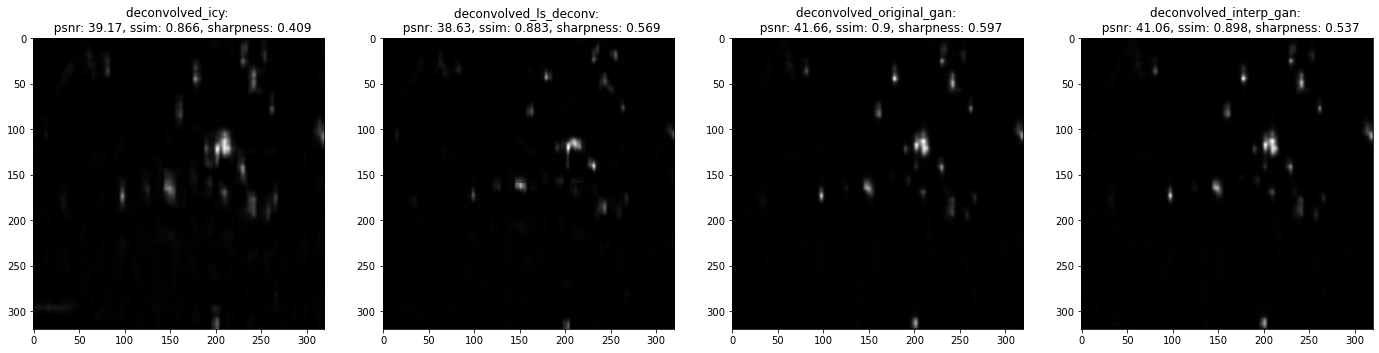

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(24)

img_true = deconvolved_gt_2#[80:220,120:260]
img_true = np.float32(img_true)
img_true -= img_true.min()
img_true /= img_true.max()
img_true -= np.median(img_true)

for ax, image, name in zip(axes.ravel(), 
                           [deconvolved_icy_2, deconvolved_ls_deconv_2, deconvolved_original_gan_2, deconvolved_interp_gan_2],
                           ['deconvolved_icy','deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan']
                          ):
    
    
    img_test = image#[80:220,120:260]
    img_test = np.float32(img_test)
    #img_test -= img_test.min()
    img_test /= img_test.max()
    img_test -= np.median(img_test)
    img_test = np.clip(img_test, 0,1)
    
    sharpness_metric = sharpness(image)
    if name != 'deconvolved_gt':
        psnr_metric = psnr(image_true=img_true, image_test=img_test)
        ssim_metric = ssim(im1=img_true, im2=img_test)
        ax.set_title(f'{name}: \n  psnr: {round(psnr_metric,2)}, ssim: {round(ssim_metric,3)}, sharpness: {round(sharpness_metric,3)}')
    else:
        ax.set_title(f'{name}: \n  psnr: gt, ssim: gt , sharpness: {round(sharpness_metric,3)}')
    
    ax.imshow(img_test, cmap='gray') #np.log(img_test+1e-9)*
    

plt.show()

## Collect distribution of metrics on lateral slices by each method

In [174]:
collection_psnr = pd.DataFrame(columns = ['bicubic', 'gan', 'deconvolved_icy', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan'], index=np.arange(0,320,1))
collection_ssim = pd.DataFrame(columns = ['bicubic', 'gan', 'deconvolved_icy', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan'], index=np.arange(0,320,1))

for i in range(320):
    if i % 10 == 0:
        clear_output()
    
    tmp_deconvolved_interp_gan = cv2.imread('deconvolved_bicubic_with_interp_esrgan/Richardson_Lucy/Final Display of RL'+'{:04d}'.format(i)+'.tif', -1)
    tmp_deconvolved_original_gan = cv2.imread('deconvolved_bicubic_with_original_esrgan/Richardson_Lucy/Final Display of RL'+'{:04d}'.format(i)+'.tif', -1)
    tmp_deconvolved_gt = cv2.imread('deconvolved_GT_new/Final Display of RL-1'+'{:04d}'.format(i)+'.tif', -1)
    tmp_deconvolved_icy = cv2.imread('deconvolved_bicubic_with_ICY_EPIDEMIC/RL/Final Display of RL'+'{:04d}'.format(i)+'.tif', -1)
    tmp_deconvolved_ls_deconv = cv2.imread('deconvolved_bicubic_with_LsDeconv V2 XYvoxelSize1000 ZvoxelSize250 TU Wien2019/deconv_'+'{:06d}'.format(i+1)+'.tif', -1)
    tmp_bicubic = cv2.imread('bicubic/crop_bicubic_C0001Z'+'{:04d}'.format(i)+'.tif', -1)
    tmp_gan = cv2.imread('int_esrgan/crop_intesrgan_C0002Z'+'{:04d}'.format(i)+'.tif', -1)
    
    
    img_true = tmp_deconvolved_gt
    img_true = np.float32(img_true)
    img_true -= np.median(img_true)
    img_true /= img_true.max()
    img_true = np.clip(img_true, 0,1)
    
    
    for image, name in zip(
        [tmp_bicubic, tmp_gan, tmp_deconvolved_icy, tmp_deconvolved_ls_deconv, tmp_deconvolved_original_gan, tmp_deconvolved_interp_gan],
        ['bicubic', 'gan', 'deconvolved_icy', 'deconvolved_ls_deconv', 'deconvolved_original_gan', 'deconvolved_interp_gan']
    ):
        img_test = np.float32(image)
        img_test -= np.median(img_test)
        img_test /= img_test.max()
        img_test = np.clip(img_test, 0,1)
        
        psnr_metric = psnr(image_true=img_true, image_test=img_test)
        ssim_metric = ssim(im1=img_true, im2=img_test)
        
        collection_psnr.loc[i, name] = psnr_metric
        collection_ssim.loc[i, name] = ssim_metric
    
    print(i)

(320, 320) bicubic
(320, 320) gan
(320, 320) deconvolved_icy
(320, 320) deconvolved_ls_deconv
(320, 320) deconvolved_original_gan
(320, 320) deconvolved_interp_gan
310
(320, 320) bicubic
(320, 320) gan
(320, 320) deconvolved_icy
(320, 320) deconvolved_ls_deconv
(320, 320) deconvolved_original_gan
(320, 320) deconvolved_interp_gan
311
(320, 320) bicubic
(320, 320) gan
(320, 320) deconvolved_icy
(320, 320) deconvolved_ls_deconv
(320, 320) deconvolved_original_gan
(320, 320) deconvolved_interp_gan
312
(320, 320) bicubic
(320, 320) gan
(320, 320) deconvolved_icy
(320, 320) deconvolved_ls_deconv
(320, 320) deconvolved_original_gan
(320, 320) deconvolved_interp_gan
313
(320, 320) bicubic
(320, 320) gan
(320, 320) deconvolved_icy
(320, 320) deconvolved_ls_deconv
(320, 320) deconvolved_original_gan
(320, 320) deconvolved_interp_gan
314
(320, 320) bicubic
(320, 320) gan
(320, 320) deconvolved_icy
(320, 320) deconvolved_ls_deconv
(320, 320) deconvolved_original_gan
(320, 320) deconvolved_interp_

### PSNR

GAN and Bicubic Upsampling

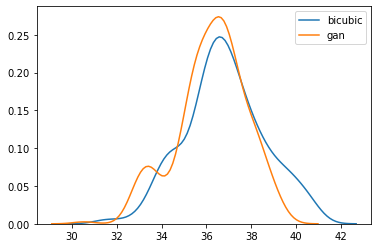

In [182]:
sns.kdeplot(collection_psnr['bicubic'])
sns.kdeplot(collection_psnr['gan'])

Upsampling + RL Deconvolution

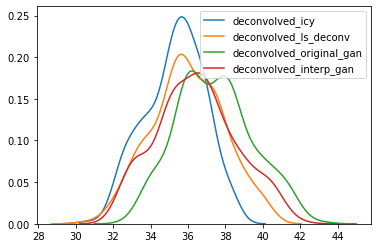

In [183]:
sns.kdeplot(collection_psnr['deconvolved_icy'])
sns.kdeplot(collection_psnr['deconvolved_ls_deconv'])
sns.kdeplot(collection_psnr['deconvolved_original_gan'])
sns.kdeplot(collection_psnr['deconvolved_interp_gan'])

### SSIM

GAN and Bicubic Upsampling

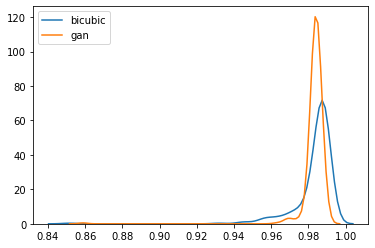

In [184]:
sns.kdeplot(collection_ssim['bicubic'])
sns.kdeplot(collection_ssim['gan'])

Upsampling + RL Deconvolution

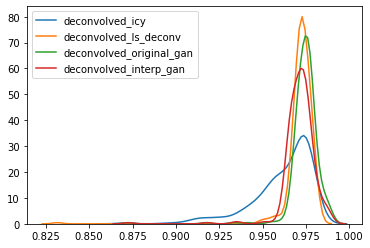

In [185]:
sns.kdeplot(collection_ssim['deconvolved_icy'])
sns.kdeplot(collection_ssim['deconvolved_ls_deconv'])
sns.kdeplot(collection_ssim['deconvolved_original_gan'])
sns.kdeplot(collection_ssim['deconvolved_interp_gan'])

In [225]:
print(f"bicubic             SSIM = {round(collection_ssim['bicubic'].median(),5)} +/- {round(collection_ssim['bicubic'].std(),5)}")
print(f"gan                 SSIM = {round(collection_ssim['gan'].median(),5)} +/- {round(collection_ssim['gan'].std(),5)}")
print(f"deconv - Epidem     SSIM = {round(collection_ssim['deconvolved_icy'].median(),5)} +/- {round(collection_ssim['deconvolved_icy'].std(),5)}")
print(f"deconv - LS-Dec     SSIM = {round(collection_ssim['deconvolved_ls_deconv'].median(),5)} +/- {round(collection_ssim['deconvolved_ls_deconv'].std(),5)}")
print(f"deconv - origin GAN SSIM = {round(collection_ssim['deconvolved_original_gan'].median(),5)} +/- {round(collection_ssim['deconvolved_original_gan'].std(),5)}")
print(f"deconv - interp GAN SSIM = {round(collection_ssim['deconvolved_interp_gan'].median(),5)} +/- {round(collection_ssim['deconvolved_interp_gan'].std(),5)}")

bicubic             SSIM = 0.98683 +/- 0.01174
gan                 SSIM = 0.98398 +/- 0.00771
deconv - Epidem     SSIM = 0.96782 +/- 0.01713
deconv - LS-Dec     SSIM = 0.9727 +/- 0.00928
deconv - origin GAN SSIM = 0.9752 +/- 0.00884
deconv - interp GAN SSIM = 0.97233 +/- 0.00918


In [226]:
print(f"bicubic             PSNR = {round(collection_psnr['bicubic'].median(),5)} +/- {round(collection_psnr['bicubic'].std(),5)}")
print(f"gan                 PSNR = {round(collection_psnr['gan'].median(),5)} +/- {round(collection_psnr['gan'].std(),5)}")
print(f"deconv - Epidem     PSNR = {round(collection_psnr['deconvolved_icy'].median(),5)} +/- {round(collection_psnr['deconvolved_icy'].std(),5)}")
print(f"deconv - LS-Dec     PSNR = {round(collection_psnr['deconvolved_ls_deconv'].median(),5)} +/- {round(collection_psnr['deconvolved_ls_deconv'].std(),5)}")
print(f"deconv - origin GAN PSNR = {round(collection_psnr['deconvolved_original_gan'].median(),5)} +/- {round(collection_psnr['deconvolved_original_gan'].std(),5)}")
print(f"deconv - interp GAN PSNR = {round(collection_psnr['deconvolved_interp_gan'].median(),5)} +/- {round(collection_psnr['deconvolved_interp_gan'].std(),5)}")

bicubic             PSNR = 36.70031 +/- 1.77717
gan                 PSNR = 36.38377 +/- 1.53904
deconv - Epidem     PSNR = 35.47598 +/- 1.58931
deconv - LS-Dec     PSNR = 35.85985 +/- 1.92193
deconv - origin GAN PSNR = 37.37597 +/- 2.01426
deconv - interp GAN PSNR = 36.44424 +/- 2.12786


<hr>

# PSF

In [3]:
def get_psf(folder):
    collector = []

    files = os.listdir(folder)
    files = sorted( [f for f in files if f.endswith('.tif')] )

    for i in range(len(files)):
        tmp = cv2.imread(os.path.join(folder, files[i]), -1)
        collector.append(np.uint16(tmp))
        
    collector = np.array(collector, dtype=np.uint16)
    return collector

In [4]:
def return_stack(psf):
    return np.hstack([psf[0,:],psf[1,:],psf[2,:],psf[3,:], psf[4,:], psf[5,:],psf[6,:],psf[7,:], psf[8,:],])

In [5]:
def convert2(psf, coef = 0.1):
    """Function to convert an image of PSF to points cloud"""
    kernel = np.ones((2,2),np.uint8)
    
    tmp = []
    for i in range(len(psf)):
        t = psf[i,:]
        t = 1*(t>(np.max(psf)*coef))
        t = t.astype(np.uint8)
        gradient = cv2.morphologyEx(t, cv2.MORPH_GRADIENT, kernel)
        tmp.append(gradient)
    
    psf_cloud = np.array(tmp)
    return psf_cloud

## Hausdorff metrics 
Taken from https://github.com/olegrgv/MLVar/blob/master/metric/3d_dist.ipynb

In [6]:
def bbox(A, P, rad):
    a = A[np.where(np.logical_and(A[:, 0] >= P[0] - rad, 
                                  A[:, 0] <= P[0] + rad))]
    b = a[np.where(np.logical_and(a[:, 1] >= P[1] - rad, 
                                  a[:, 1] <= P[1] + rad))]
    c = b[np.where(np.logical_and(b[:, 2] >= P[2] - rad, 
                                  b[:, 2] <= P[2] + rad))]
    return c


def v_hausdorff(surf_a, surf_b):

    # get two arrays (grids [X,Y,Z]) as input, find the Hausdorff distane between "surf_a" and "surf_b"
    dists = []

    l = len(surf_a)

    for i in range(l):

        # walking through all the points of surf_a
        dist_min = 1000.0
        radius = 0
        boxmod = np.empty(shape=(0, 0, 0))

        # increasing the cube size around the point until the cube contains at least 1 point
        while boxmod.shape[0] == 0:
            boxmod = bbox(surf_b, surf_a[i], radius)
            radius += 1

        # to avoid getting false result (point is close to the edge, but along an axis another one is closer),
        # increasing the size of the cube
        boxmod = bbox(surf_b, surf_a[i], radius * math.sqrt(3))

        for j in range(len(boxmod)):
            # iterate oer the small number of points to find the minimum distance
            dist = np.linalg.norm(surf_a[i] - boxmod[j])
            if dist_min > dist:
                dist_min = dist

        dists.append(dist_min)

    return np.max(dists)

# Synthetic PSF

In [7]:
folder = './data/psf_extraction_synthetic_data_05052020/'
os.listdir(folder)

['.imaris_cache', 'psf_encoded', 'psf_extracted']

In [8]:
psf_encoded = get_psf(folder+'psf_encoded/')
psf_extracted = get_psf(folder+'psf_extracted/')

In [9]:
psf_encoded.shape, psf_extracted.shape

((7, 31, 31), (7, 31, 31))

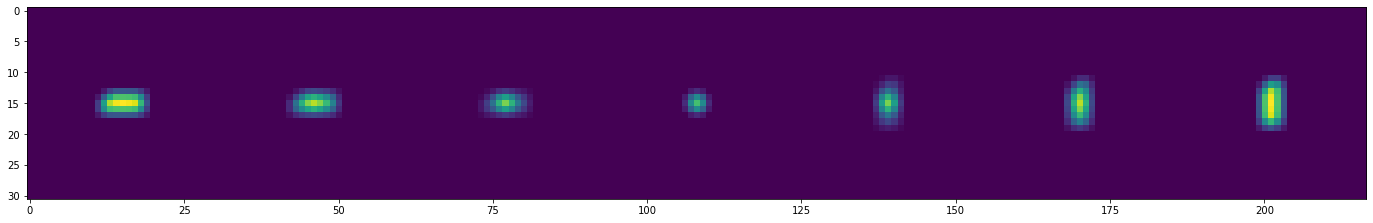

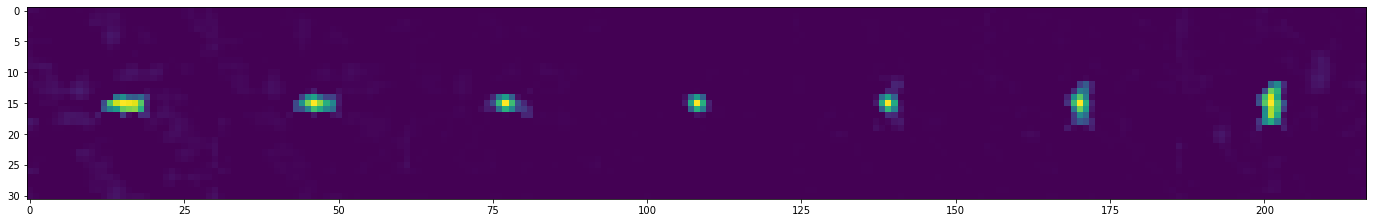

In [10]:
for psf in [psf_encoded, psf_extracted]:
    plt.figure(figsize=(24,5))
    plt.imshow(np.hstack([psf[0,:],psf[1,:],psf[2,:],psf[3,:], psf[4,:], psf[5,:],psf[6,:]]))
    plt.show()

### Calculate Hausdorff distance

In [11]:
cloud_encoded = convert2(psf_encoded)
cloud_extracted = convert2(psf_extracted)

In [25]:
hausdorff_synthetic = pd.DataFrame(columns = ['en_ex','ex_en','max'], index = np.arange(0,7,1))

for i in range(7):
    k1 = cloud_encoded[i,:]
    k2 = cloud_extracted[i,:]
    
    dir_en_ex = v_hausdorff(k1, k2)
    dir_ex_en = v_hausdorff(k2, k1)
    hausdorff_synthetic.loc[i, 'en_ex'] = dir_en_ex
    hausdorff_synthetic.loc[i, 'ex_en'] = dir_ex_en
    hausdorff_synthetic.loc[i, 'max'] = max(dir_en_ex, dir_ex_en)
    print(i, 'en -> ex', round(dir_en_ex,3), 'ex -> en', round(dir_ex_en,3), 'max',round(max(dir_en_ex, dir_ex_en),3) )

0 en -> ex 2.828 ex -> en 2.646 max 2.828
1 en -> ex 1.732 ex -> en 1.732 max 1.732
2 en -> ex 2.0 ex -> en 2.0 max 2.0
3 en -> ex 1.414 ex -> en 1.414 max 1.414
4 en -> ex 1.414 ex -> en 0.0 max 1.414
5 en -> ex 1.732 ex -> en 1.732 max 1.732
6 en -> ex 2.0 ex -> en 1.732 max 2.0


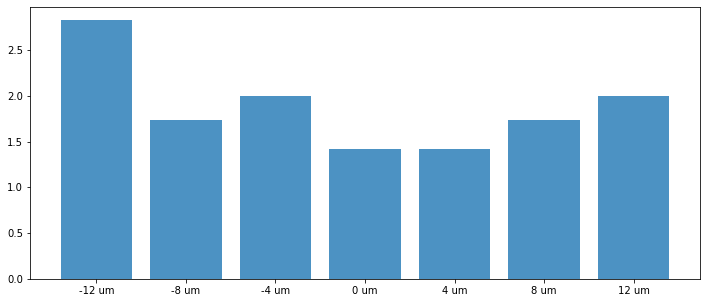

In [16]:
plt.figure(figsize=(12,5))
plt.bar(np.arange(0,7,1), hausdorff_synthetic['max'], alpha=0.8)
plt.xticks(np.arange(0,7,1), [f'{i} um' for i in (hausdorff_synthetic.index.values-3)*4])
plt.show()

<hr>

# Real Data PSF

In [17]:
folder = './data/psf_extraction_real_data_operational_substack_LS_03052020/'
os.listdir(folder)

['estimated_epidemic_icy_package',
 'estimated_interpolated_esrgan',
 'estimated_original_esrgan',
 'modelled_ground_truth']

In [18]:
psf_gt = get_psf(os.path.join(folder, 'modelled_ground_truth/'))
psf_original = get_psf(os.path.join(folder,'estimated_original_esrgan/'))
psf_interp = get_psf(os.path.join(folder,'estimated_interpolated_esrgan/'))
psf_epidemic = get_psf(os.path.join(folder,'estimated_epidemic_icy_package/'))

In [19]:
psf_epidemic.shape,psf_gt.shape, psf_interp.shape

((9, 60, 60), (9, 60, 60), (9, 60, 60))

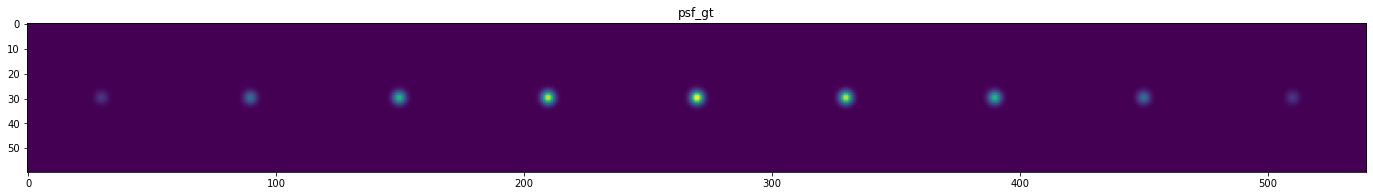

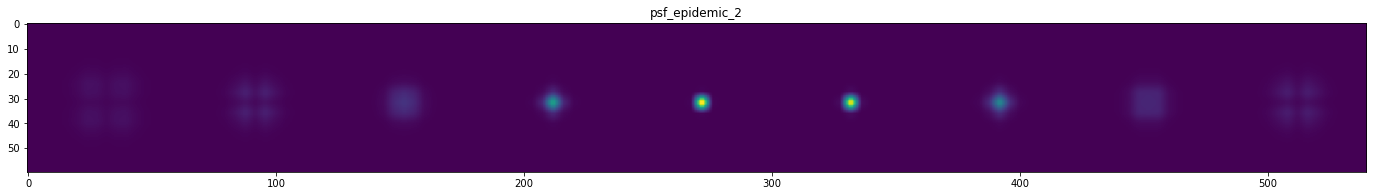

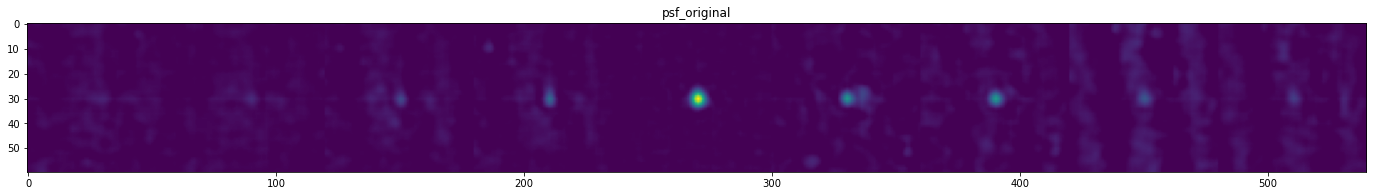

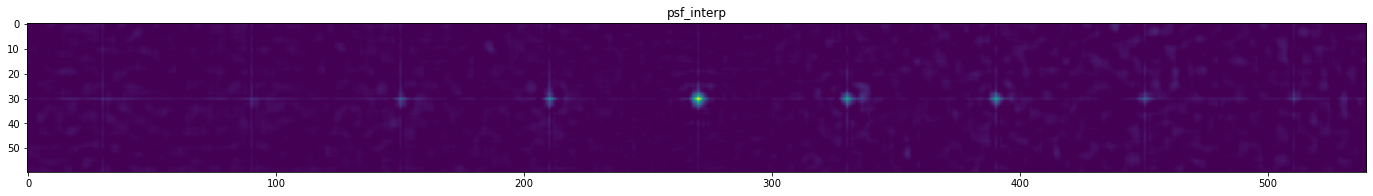

In [20]:
for name, psf in zip(
    ['psf_gt', 'psf_epidemic_2', 'psf_original', 'psf_interp'],
    [psf_gt, psf_epidemic, psf_original, psf_interp]
):
    plt.figure(figsize=(24,5))
    plt.imshow(np.hstack([psf[0,:],psf[1,:],psf[2,:],psf[3,:], psf[4,:], psf[5,:],psf[6,:],psf[7,:], psf[8,:],]))
    plt.title(name)
    plt.show()

## Calculate Hausdorff metric along axis in stacks

In [31]:
k_gt = convert2(psf_gt*(psf_gt>0))
k_gt = np.array(np.nonzero(k_gt)).T

k_ep = convert2(psf_epidemic*(psf_gt>0))
k_ep = np.array(np.nonzero(k_ep)).T

k_or = convert2(psf_original*(psf_gt>0))
k_or = np.array(np.nonzero(k_or)).T

k_in = convert2(psf_interp*(psf_gt>0))
k_in = np.array(np.nonzero(k_in)).T

ICY Epidemic

In [32]:
k1 = k_gt
hausdorff_real = pd.DataFrame(columns = ['EpiDEMIC', 'Original GAN', 'Interpolated GAN'], index = [0])

for k2, name in zip([k_ep, k_or, k_in], ['EpiDEMIC', 'Original GAN', 'Interpolated GAN']):
    dir_en_ex = v_hausdorff(k1, k2)
    dir_ex_en = v_hausdorff(k2, k1)
    hausd_m = round(np.max([dir_en_ex, dir_ex_en]),2)
    
    hausdorff_real.loc[0, name] = hausd_m
    
hausdorff_real

,EpiDEMIC,Original GAN,Interpolated GAN
0,3.46,2.24,3


In [16]:
def stack_hausdorff(psf_1, psf_2):
    dir_1 = directed_hausdorff(psf_1[4,:,:], psf_2[4,:,:])[0]
    dir_2 = directed_hausdorff(psf_2[4,:,:], psf_1[4,:,:])[0]
    z_axis = max(dir_1, dir_2)
    
    dir_1 = directed_hausdorff(psf_1[:,30,:], psf_2[:,30,:])[0]
    dir_2 = directed_hausdorff(psf_2[:,30,:], psf_1[:,30,:])[0]
    x_axis = max(dir_1, dir_2)
    
    dir_1 = directed_hausdorff(psf_1[:,:,30], psf_2[:,:,30])[0]
    dir_2 = directed_hausdorff(psf_2[:,:,30], psf_1[:,:,30])[0]
    y_axis = max(dir_1, dir_2)
    
    return x_axis, y_axis, z_axis

<hr>

# Optical Transfer Function

In [33]:
otf_gt = np.fft.fftn(psf_gt)
otf_epidemic = np.fft.fftn(psf_epidemic)
otf_original = np.fft.fftn(psf_original)
otf_interp = np.fft.fftn(psf_interp)

In [34]:
def otf_3d(otf):
    ot = []
    for k in range(9):
        ot.append(otf[k, k*3,k*3]/otf.max())
        ot.append(otf[k, k*3+1,k*3+1]/otf.max())
        ot.append(otf[k, k*3+2,k*3+2]/otf.max())
    return ot

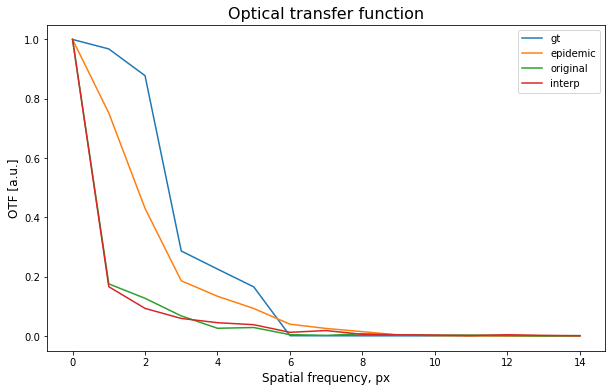

In [39]:
plt.figure(figsize=(10,6))
plt.plot(np.abs(otf_3d(otf_gt))[:15], label='gt')
plt.plot(np.abs(otf_3d(otf_epidemic))[:15], label='epidemic')
plt.plot(np.abs(otf_3d(otf_original))[:15], label='original')
plt.plot(np.abs(otf_3d(otf_interp))[:15], label='interp')
plt.title('Optical transfer function', fontsize=16)
plt.xlabel('Spatial frequency, px', fontsize=12)
plt.ylabel('OTF [a.u.]', fontsize=12)
plt.legend()
plt.show()